<a href="https://colab.research.google.com/github/tonyamf/ANN/blob/main/Untitled_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load  libraries

In [59]:
!pip install face-recognition
!pip install unicodecsv
!pip install scikit-optimize
!pip install livelossplot

In [68]:
from skopt import BayesSearchCV
from imutils import face_utils
import PIL.Image as Image
import argparse
import imutils
import dlib
import cv2
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt
import scipy.misc
import face_recognition
import PIL
import math
import re
import keras
from scipy.stats import *
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from livelossplot import PlotLossesKeras
from imutils import face_utils
import argparse
import imutils
import dlib
import cv2
import pandas as pd
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import scipy.misc
import face_recognition
import PIL
from PIL import Image, ImageStat
import math
from scipy.stats import *
import re
from scipy import ndimage 

# Mount Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [70]:
# load facial key points data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/icml_face_data.csv")

#data_ = pd.read_csv("C:/Users/Antonio franco/Documents/Computer vision/dataset/DataExt.csv")

In [71]:
df = pd.DataFrame(df)
df.columns = ['emotion', 'usage', 'pixels']
df.columns

Index(['emotion', 'usage', 'pixels'], dtype='object')

In [72]:
df['pixel'] = df_ =pd.DataFrame(df['pixels'].copy())

In [73]:
df['pixels'] = df['pixels'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(48, 48))

In [64]:
df['pixels'][0].shape

(48, 48)

In [65]:
df.head()

,emotion,usage,pixels
0,0,Training,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ..."
1,0,Training,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,..."
2,2,Training,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,..."
3,4,Training,"[[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ..."
4,6,Training,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2..."


# Key points detection

In [74]:
#chin left_eyebrow right_eyebrow nose_bridge nose_tip left_eye right_eye top_lip bottom_lip
df["landmarks"] = ""
for j in range(0,len(df)):
    arr = np.array(df['pixels'][j])
    im = Image.fromarray(arr.astype(np.uint8), mode='L')
    im.save('/content/drive/MyDrive/Colab Notebooks/my.png')
    img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/my.png', cv2.IMREAD_GRAYSCALE)
    df["landmarks"][j] = face_recognition.face_landmarks(img)
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Distance signiture Features

## Computing Distance

In [75]:
df["distance"] = ""
for j in range(0, len(df)):
    if len(df["landmarks"][j]) == 0:
        continue
    else:
        xs = []
        ys = []
        df["distance"][j] = []
        for landmark in df["landmarks"][j]:
            for k, v in landmark.items():
                if k == 'chin':
                    continue
                elif k == 'top_lip':
                    xs += v[0][0],  v[3][0], v[6][0]
                    ys += v[0][1],  v[3][1], v[6][1]
                elif k == 'bottom_lip':
                    xs.append(v[3][0])
                    ys.append(v[3][1])
                elif k == 'nose_tip':
                    xs += v[0][0],  v[4][0]
                    ys += v[0][1],  v[4][1]
                elif k == 'nose_bridge':
                    xs.append(v[3][0])
                    ys.append(v[3][1])
                elif k == 'right_eyebrow':
                    xs += v[0][0], v[2][0], v[4][0]
                    ys += v[0][1], v[2][1], v[4][1]
                elif k == 'left_eyebrow':
                    xs += v[0][0], v[2][0], v[4][0]
                    ys += v[0][1], v[2][1], v[4][1]
                else:
                    xs += [x[0] for x in v]
                    ys += [x[1] for x in v]
                
        for i in range(0, len(ys)-1):
            for s in range(i+1, len(ys)):
                if ys[i] < 0 or ys[i] > 47 or xs[i] < 0 or xs[i] > 47 or ys[s] < 0 or ys[s] > 47 or xs[s] < 0 or xs[s] > 47:
                  continue
                df["distance"][j].append(math.sqrt( pow(xs[i] - xs[s], 2) + pow(ys[i]- ys[s], 2)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Normalized Distance

In [76]:
dfO =pd.DataFrame(df[df['distance'] != ""].copy())
dfO.reset_index(inplace = True, drop = True) 

In [ ]:
df_ =pd.DataFrame(df[df['distance'] != ""].copy())
df_.reset_index(inplace = True, drop = True) 
sums = []

for d in range(0, len(df_["distance"][0])):
    sum = 0
    for i in range(0, len(df_)):
      if len(df_["distance"][i]) <= d:
        continue
      sum += df_["distance"][i][d]
    sums.append(sum)


In [ ]:
df_["NormalizedDistance"] = ""

for j in range(0, len(df_)):
    df_["NormalizedDistance"][j] = []

    for d in range(0, len(df_["distance"][j])):
        if sums[d] == 0:
            df_["NormalizedDistance"][j].append(0.0)
        else:
            df_["NormalizedDistance"][j].append(df_["distance"][j][d]/sums[d])

## Stability Indes of distance signiture

In [ ]:
df_["StabilityIndex_D"] = ""
for j in range(0, len(df_)):
    dif = 0
    for d in range(10, len(df_["NormalizedDistance"][j])):
        dif += abs( df_["NormalizedDistance"][j][d-10] + df_["NormalizedDistance"][j][d] + 10 * (- df_["NormalizedDistance"][j][d-1] 
        - df_["NormalizedDistance"][j][d-2] - df_["NormalizedDistance"][j][d-3] - df_["NormalizedDistance"][j][d-4] - df_["NormalizedDistance"][j][d-5] 
        - df_["NormalizedDistance"][j][d-6] - df_["NormalizedDistance"][j][d-7] - df_["NormalizedDistance"][j][d-8] - df_["NormalizedDistance"][j][d-9]) ) 
    df_["StabilityIndex_D"][j] = abs(dif)

    

In [ ]:
df_.head()

## Distance statictic

In [ ]:
df_["Skewness_D"] = ""
df_["Kurtosis_D"] = ""
df_['Moment_D_1'] = ""
df_['Moment_D_2'] = ""
df_['Moment_D_3'] = ""
df_['Moment_D_4'] = ""
df_["Entropy_D"] = ""
df_["Range_D"] = ""

for j in range(0, len(df_)):
    stats = scipy.stats.describe(df_["NormalizedDistance"][j])
    df_["Skewness_D"][j] = stats.skewness
    df_["Kurtosis_D"][j] = stats.kurtosis
    df_["Range_D"][j] = np.array(df_["NormalizedDistance"][j]).max() - np.array(df_["NormalizedDistance"][j]).min()
    df_['Moment_D_1'][j] = scipy.stats.moment(df_["NormalizedDistance"][j], moment=1)
    df_['Moment_D_2'][j]= scipy.stats.moment(df_["NormalizedDistance"][j], moment=2)
    df_['Moment_D_3'][j] = scipy.stats.moment(df_["NormalizedDistance"][j], moment=3)
    df_['Moment_D_4'][j] = scipy.stats.moment(df_["NormalizedDistance"][j], moment=4)
    df_["Entropy_D"][j] = scipy.stats.entropy(df_["NormalizedDistance"][j])

# Shape signiture Features

## Compute shape signiture

In [ ]:
df_["shape"] = ""
for j in range(0, len(df_)):
    xs = []
    ys = []
    df_["shape"][j] = []
    for landmark in df_["landmarks"][j]:
        for k, v in landmark.items():
            if k == 'chin':
                continue
            elif k == 'top_lip':
                xs += v[0][0],  v[3][0], v[6][0]
                ys += v[0][1],  v[3][1], v[6][1]
            elif k == 'bottom_lip':
                xs.append(v[3][0])
                ys.append(v[3][1])
            elif k == 'nose_tip':
                xs += v[0][0],  v[4][0]
                ys += v[0][1],  v[4][1]
            elif k == 'nose_bridge':
                xs.append(v[3][0])
                ys.append(v[3][1])
            elif k == 'right_eyebrow':
                xs += v[0][0], v[2][0], v[4][0]
                ys += v[0][1], v[2][1], v[4][1]
            elif k == 'left_eyebrow':
                xs += v[0][0], v[2][0], v[4][0]
                ys += v[0][1], v[2][1], v[4][1]
            else:
                xs += [x[0] for x in v]
                ys += [x[1] for x in v]
    for i in range(0, len(ys)-2):
        for s in range(i+1, len(ys)-1):
            for z in range(s+1, len(ys)):
                if ys[i] < 0 or ys[i] > 47 or xs[i] < 0 or xs[i] > 47 or ys[s] < 0 or ys[s] > 47 or xs[s] < 0 or xs[s] > 47 or ys[z] < 0 or ys[z] > 47 or xs[z] < 0 or xs[z] > 47:
                  continue
                a = (xs[i] * (ys[s] - ys[z]) +
                     xs[s] * (ys[z] - ys[i]) + 
                     xs[z] * (ys[i] - ys[s])) 
                if a != 0: 
                    ab = math.sqrt( pow(xs[i] - xs[s], 2) + pow(ys[i]- ys[s], 2))
                    bc = math.sqrt( pow(xs[s] - xs[z], 2) + pow(ys[s]- ys[z], 2))
                    ca = math.sqrt( pow(xs[z] - xs[i], 2) + pow(ys[z]- ys[i], 2))
                    h = (ab + bc + ca)/2
                    result = math.sqrt( h * (h-ab) * (h-bc) *(h-ca)) / pow(h*2, 2)
                    df_["shape"][j].append(result)

## Normalized shape

In [ ]:
sums = []

for d in range(0, 2301):
    sum = 0
    for i in range(0, len(df_)):
        if len(df_["shape"][i]) <= d:
            continue
        sum += df_["shape"][i][d]
    sums.append(sum)


df_["NormalizedShape"] = ""

for j in range(0, len(df_)):

    df_["NormalizedShape"][j] = []
    for d in range(0, len(df_["shape"][j])):
        if len(sums) <= d:
          continue
        elif sums[d] == 0:
            df_["NormalizedShape"][j].append(0.0)
        else:
            df_["NormalizedShape"][j].append(df_["shape"][j][d]/sums[d])

## Stability index shape signiture

In [ ]:
df_["StabilityIndex_S"] = ""
for j in range(0, len(df_)):
    dif = 0
    for d in range(8, len(df_["NormalizedShape"][j])):
        dif += abs( df_["NormalizedShape"][j][d-8] + df_["NormalizedShape"][j][d] + 8 * (- df_["NormalizedShape"][j][d-1] 
        - df_["NormalizedShape"][j][d-2] - df_["NormalizedShape"][j][d-3] - df_["NormalizedShape"][j][d-4] 
        - df_["NormalizedShape"][j][d-5] - df_["NormalizedShape"][j][d-6] - df_["NormalizedShape"][j][d-7]) ) 
    df_["StabilityIndex_S"][j] = dif

## Shape statistic

In [ ]:
df_["Skewness_S"] = ""
df_["Kurtosis_S"] = ""
df_['Moment_S_1'] = ""
df_['Moment_S_2'] = ""
df_['Moment_S_3'] = ""
df_['Moment_S_4'] = ""
df_["Entropy_S"] = ""
df_["Range_S"] = ""

for j in range(0, len(df_)):
    if not df_["NormalizedShape"][j]:
      df_["NormalizedShape"][j] = 0
    stats = scipy.stats.describe(df_["NormalizedShape"][j])
    df_["Skewness_S"][j] = stats.skewness
    df_["Kurtosis_S"][j] = stats.kurtosis
    df_["Range_S"][j] = np.array(df_["NormalizedShape"][j]).max() - np.array(df_["NormalizedShape"][j]).min()
    df_["Moment_S_1"][j]= scipy.stats.moment(df_["NormalizedShape"][j], moment=1)
    df_["Moment_S_2"][j]= scipy.stats.moment(df_["NormalizedShape"][j], moment=2)
    df_["Moment_S_3"][j]=scipy.stats.moment(df_["NormalizedShape"][j], moment=3)
    df_["Moment_S_4"][j]=scipy.stats.moment(df_["NormalizedShape"][j], moment=4)
    df_["Entropy_S"][j] = scipy.stats.entropy(df_["NormalizedShape"][j])

# Texture

## Textute signiture

In [ ]:
df_["texture"] = ""
for j in range(0, len(df_)):
    xs = []
    ys = []
    df_["texture"][j] = []
    for landmark in df_["landmarks"][j]:
        for k, v in landmark.items():
            if k == 'chin':
                continue
            elif k == 'top_lip':
                xs += v[0][0],  v[3][0], v[6][0]
                ys += v[0][1],  v[3][1], v[6][1]
            elif k == 'bottom_lip':
                xs.append(v[3][0])
                ys.append(v[3][1])
            elif k == 'nose_tip':
                xs += v[0][0],  v[4][0]
                ys += v[0][1],  v[4][1]
            elif k == 'nose_bridge':
                xs.append(v[3][0])
                ys.append(v[3][1])
            elif k == 'right_eyebrow':
                xs += v[0][0], v[2][0], v[4][0]
                ys += v[0][1], v[2][1], v[4][1]
            elif k == 'left_eyebrow':
                xs += v[0][0], v[2][0], v[4][0]
                ys += v[0][1], v[2][1], v[4][1]
            else:
                xs += [x[0] for x in v]
                ys += [x[1] for x in v]
    for i in range(0, len(ys)):
        c = 0
        n = 0
        temp = 0
        p = 0
        op = []
        if ys[i] < 0 or ys[i] > 47 or xs[i] < 0 or xs[i] > 47:
          continue
        else:
          for ii in range(-3, 4):
              for jj in range(-3, 4):
                  if ys[i] + ii < 48 and ys[i] + ii >= 0 and xs[i] + jj < 48 and xs[i] + jj >= 0:
                      p = p + df_['pixels'][j][ys[i] + ii][xs[i] + jj]
                      c = c+1

          p = (p + df_['pixels'][j][ys[i]][xs[i]]) / (c+1)
          if ys[i] + 4 < 48 and ys[i] + 4 >= 0 and xs[i] - 4 < 48 and xs[i] - 4 >= 0:
              op.append(df_['pixels'][j][ys[i] + 4][xs[i] - 4])
          else:
              op.append(0)

          for mm in range(-3, 4):
              if ys[i] + 4 < 48 and ys[i] + 4 >= 0 and xs[i] + mm < 48 and xs[i] + mm >= 0:
                  temp = temp + df_['pixels'][j][ys[i] + 4][xs[i] + mm]
                  n = n + 1
          if n == 0:
              op.append(0)
          else:
              op.append(temp/n)
          temp = 0 
          n =0

          if ys[i] + 4 < 48 and ys[i] + 4 >= 0 and xs[i] + 4 < 48 and xs[i] + 4 >= 0:
              op.append(df_['pixels'][j][ys[i] + 4][xs[i] + 4])
          else:
              op.append(0)


          for mm in range(-3, 4):
              if ys[i] + mm < 48 and ys[i] + mm >= 0 and xs[i] + 4 < 48 and xs[i] + 4 >= 0:
                  temp = temp + df_['pixels'][j][ys[i] + mm][xs[i] + 4]
                  n = n + 1
          if temp == 0:
              op.append(0)
          else:
              op.append(temp/n)
          temp = 0 
          n =0

          if ys[i] - 4 < 48 and ys[i] - 4 >= 0 and xs[i] + 4 < 48 and xs[i] + 4 >= 0:
              op.append(df_['pixels'][j][ys[i] - 4][xs[i] + 4])
          else:
              op.append(0)


          for mm in range(-3, 4):
              if ys[i] - 4 < 48 and ys[i] - 4 >= 0 and xs[i] + mm < 48 and xs[i] + mm >= 0:
                  temp = temp + df_['pixels'][j][ys[i] - 4][xs[i] + mm]
                  n = n + 1
          if temp == 0:
              op.append(0)
          else:
              op.append(temp/n)
          temp = 0 
          n =0

          if ys[i] - 4 < 48 and ys[i] - 4 >= 0 and xs[i] - 4 < 48 and xs[i] - 4 >= 0:
              op.append(df_['pixels'][j][ys[i] - 4][xs[i] - 4])
          else:
              op.append(0)


          for mm in range(-3, 4):
              if ys[i] + mm < 48 and ys[i] + mm >= 0 and xs[i] - 4 < 48 and xs[i] - 4 >= 0:
                  temp = temp + df_['pixels'][j][ys[i] + mm][xs[i] - 4]
                  n = n + 1
          if temp == 0:
              op.append(0)
          else:
              op.append(temp/n)
          g = 0
          for ggg in range(0,8):
              tem = 1 
              if p > op[ggg]:
                  tem = 0
              g = g + tem * pow(2, 7-ggg)
          df_["texture"][j].append(g)

## Normalized texture signiture

In [ ]:
sums = []

for d in range(0, 26):
    sum = 0
    for i in range(0, len(df_)):
      if len(df_["texture"][i]) <= d:
        continue
      sum += df_["texture"][i][d]
    sums.append(sum)
df_["NormalizedTexture"] = ""
for j in range(0, len(df_)):
    df_["NormalizedTexture"][j] = []
    for d in range(0, len(df_["texture"][j])):
        if sums[d] == 0:
            df_["NormalizedTexture"][j].append(0.0)
        else:
            df_["NormalizedTexture"][j].append(df_["texture"][j][d]/sums[d])

## Stability Index shape signiture

In [ ]:
df_["StabilityIndex_T"] = ""
for j in range(0, len(df_)):
    dif = 0
    for d in range(8, len(df_["NormalizedTexture"][j])):
        dif += abs( df_["NormalizedTexture"][j][d-8] + df_["NormalizedTexture"][j][d] + 8 * (- df_["NormalizedTexture"][j][d-1] 
        - df_["NormalizedTexture"][j][d-2] - df_["NormalizedTexture"][j][d-3] - df_["NormalizedTexture"][j][d-4] 
        - df_["NormalizedTexture"][j][d-5] - df_["NormalizedTexture"][j][d-6] - df_["NormalizedTexture"][j][d-7]) ) 
    df_["StabilityIndex_T"][j] = dif

## Texture Statustic

In [ ]:
df_["Skewness_T"] = ""
df_["Kurtosis_T"] = ""
df_['Moment_T_1'] = ""
df_['Moment_T_2'] = ""
df_['Moment_T_3'] = ""
df_['Moment_T_4'] = ""
df_["Entropy_T"] = ""
df_["Range_T"] = ""
for j in range(0, len(df_)):
    stats = scipy.stats.describe(df_["NormalizedTexture"][j])
    df_["Skewness_T"][j] = stats.skewness
    df_["Kurtosis_T"][j] = stats.kurtosis
    df_["Range_T"][j] = np.array(df_["NormalizedTexture"][j]).max() - np.array(df_["NormalizedTexture"][j]).min()
    df_["Moment_T_1"][j]=scipy.stats.moment(df_["NormalizedTexture"][j], moment=1)
    df_["Moment_T_2"][j]=scipy.stats.moment(df_["NormalizedTexture"][j], moment=2)
    df_["Moment_T_3"][j]=scipy.stats.moment(df_["NormalizedTexture"][j], moment=3)
    df_["Moment_T_4"][j]=scipy.stats.moment(df_["NormalizedTexture"][j], moment=4)
    df_["Entropy_T"][j] = scipy.stats.entropy(df_["NormalizedTexture"][j])

# *Save Data*

In [ ]:

#with open('/content/drive/MyDrive/Colab Notebooks/DataFrame.csv' , 'wb') as f:
#    np.savetxt(f, df_, delimiter=' ', newline='\n')
df_.to_csv(r'/content/drive/MyDrive/Colab Notebooks/DataFrame.csv')


# MLP Model

## *Import data*

In [ ]:
#df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/icml_face_data.csv")
df_ = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataFrame.csv')

In [ ]:
select = ['emotion',	'StabilityIndex_D',	'Skewness_D',	'Kurtosis_D',	'Moment_D_1',	'Moment_D_2',	'Moment_D_3',	'Moment_D_4',	'Entropy_D',	'Range_D',
'StabilityIndex_S',	'Skewness_S',	'Kurtosis_S',	'Moment_S_1',	'Moment_S_2',	'Moment_S_3',	'Moment_S_4',	'Entropy_S',	'Range_S',	
'StabilityIndex_T',	'Skewness_T',	'Kurtosis_T',	'Moment_T_1',	'Moment_T_2',	'Moment_T_3',	'Moment_T_4',	'Entropy_T',	'Range_T']
df_[select] =df_[select].apply(pd.to_numeric, errors='coerce')


##PreProcessing

## Data selection

In [ ]:
select = ['emotion', 'usage',	'StabilityIndex_D',	'Skewness_D',	'Kurtosis_D',	'Moment_D_1',	'Moment_D_2',	'Moment_D_3',	'Moment_D_4',	'Entropy_D',	'Range_D',
'StabilityIndex_S',	'Skewness_S',	'Kurtosis_S',	'Moment_S_1',	'Moment_S_2',	'Moment_S_3',	'Moment_S_4',	'Entropy_S',	'Range_S',	
'StabilityIndex_T',	'Skewness_T',	'Kurtosis_T',	'Moment_T_1',	'Moment_T_2',	'Moment_T_3',	'Moment_T_4',	'Entropy_T',	'Range_T']

dataframe = dfO_[select]
df_train = dataframe.loc[dataframe['usage'] == 'Training']
df_test = dataframe.loc[dataframe['usage'] != 'Training']
df_train_X = df_train.iloc[:, 2:len(dataframe.iloc[0,])]
df_train_Y = df_train.iloc[:, 0]
df_test_X = df_test.iloc[:, 2:len(dataframe.iloc[0,])]
df_test_Y = df_test.iloc[:, 0]

## Data Normalization

In [ ]:
sc = StandardScaler()
df_train_X = sc.fit_transform(df_train_X)
df_test_X = sc.transform(df_test_X)

In [ ]:
df_train_X = df_train_X.astype("float32")
df_test_X = df_test_X.astype("float32")

In [ ]:
len(df_train_X)

39249

In [ ]:
y_train = tf.keras.utils.to_categorical(df_train_Y, 7)
y_test = tf.keras.utils.to_categorical(df_test_Y, 7)

## Model

In [ ]:

number_of_features = 27
def DST_network(optimizer, loss, activation, weigth, dropout):
  
  network = Sequential()

  network.add(layers.Dropout(dropout, input_shape=(number_of_features,)))

  network.add(layers.Dense(units=512, kernel_regularizer=keras.regularizers.l2(weigth), activation = activation))
  network.add(Dropout(dropout))
  
  network.add(layers.Dense(units=64, kernel_regularizer=keras.regularizers.l2(weigth), activation = activation))
  network.add(Dropout(dropout))

  network.add(layers.Dense(units=16, kernel_regularizer=keras.regularizers.l2(weigth), activation = activation))
  network.add(Dropout(dropout))

  network.add(layers.Dense(units=7, activation="softmax"))
  network.compile(loss= loss, optimizer=optimizer, metrics=["accuracy"]) 

  return network


In [ ]:
neural_network = KerasClassifier(build_fn=DST_network, verbose=1)

epochs = np.arange(16, 64, 16)
batches = np.arange(8, 256, 62)
optimizers = ["rmsprop", "adam", 'sgd', 'Ftrl']
losses = ['categorical_crossentropy', 'categorical_hinge', 'mean_squared_logarithmic_error']
activations = ['relu', 'sigmoid',  'tanh']
weigths = np.arange(0.0, 0.9, 0.01)
dropouts = np.arange(0.0, 0.9, 0.01)

hyperparameters = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, loss=losses, activation=activations, weigth=weigths, dropout=dropouts)

bayes = BayesSearchCV(estimator=neural_network, search_spaces=hyperparameters, n_jobs=25, n_iter=10, n_points=25, cv=3)

bayes_result = bayes.fit(df_train_X, y_train)

Epoch 1/32
152/152 [==============================] - 2s 3ms/step - loss: 0.0605 - accuracy: 0.2386
Epoch 2/32
152/152 [==============================] - 0s 3ms/step - loss: 0.0577 - accuracy: 0.2880
Epoch 3/32
152/152 [==============================] - 0s 3ms/step - loss: 0.0564 - accuracy: 0.3026
Epoch 4/32
152/152 [==============================] - 0s 3ms/step - loss: 0.0560 - accuracy: 0.3177
Epoch 5/32
152/152 [==============================] - 0s 3ms/step - loss: 0.0559 - accuracy: 0.3183
Epoch 6/32
152/152 [==============================] - 0s 3ms/step - loss: 0.0557 - accuracy: 0.3203
Epoch 7/32
152/152 [==============================] - 0s 3ms/step - loss: 0.0557 - accuracy: 0.3149
Epoch 8/32
152/152 [==============================] - 0s 3ms/step - loss: 0.0555 - accuracy: 0.3251
Epoch 9/32
152/152 [==============================] - 0s 3ms/step - loss: 0.0550 - accuracy: 0.3331
Epoch 10/32
152/152 [==============================] - 0s 3ms/step - loss: 0.0551 - accuracy: 0.3310

In [ ]:
bayes_result.best_params_

OrderedDict([('activation', 'tanh'),
             ('batch_size', 132),
             ('dropout', 0.35000000000000003),
             ('epochs', 32),
             ('loss', 'mean_squared_logarithmic_error'),
             ('optimizer', 'adam'),
             ('weigth', 0.0)])

In [ ]:
bayes_result.best_score_

0.3652922365981474

In [ ]:
predicted = bayes_result.best_estimator_.predict(df_test_X)

38/38 [==============================] - 0s 1ms/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
validation_set

In [ ]:
y_test[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

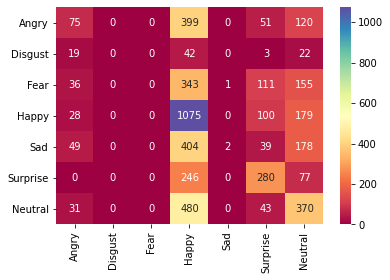

In [ ]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(df_test_Y, predicted)
#time_elapsed = (time.perf_counter() - time_start)
import seaborn as sns

sns.heatmap(matrix, annot=True, fmt='d',cmap='Spectral', 
            yticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
            xticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
#print ("%5.1f secs" % (time_elapsed))

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(df_test_Y, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.32      0.12      0.17       645
           1       0.00      0.00      0.00        86
           2       0.00      0.00      0.00       646
           3       0.36      0.78      0.49      1382
           4       0.67      0.00      0.01       672
           5       0.45      0.46      0.46       603
           6       0.34      0.40      0.37       924

    accuracy                           0.36      4958
   macro avg       0.30      0.25      0.21      4958
weighted avg       0.35      0.36      0.28      4958



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
DST_network('adam', 'mean_squared_logarithmic_error', 'tanh', 0.0, 0.35000000000000003).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 27)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               14336     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0

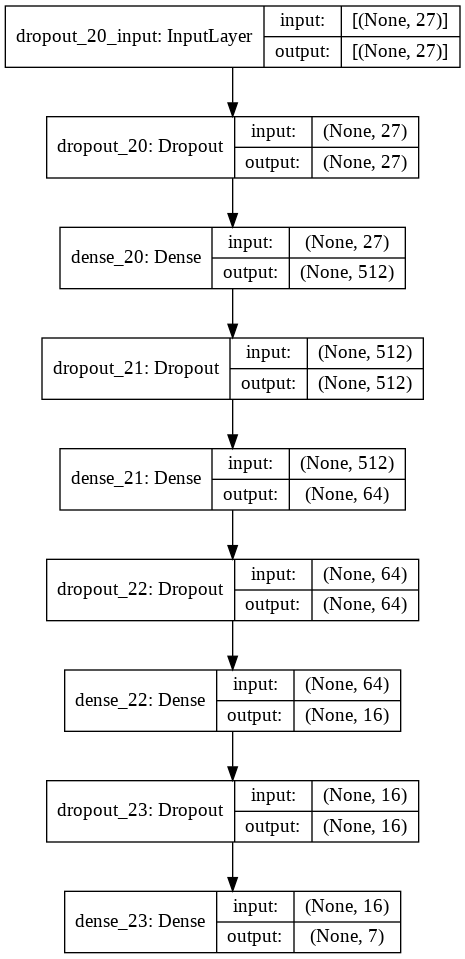

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

SVG(model_to_dot(DST_network(bayes_result.best_params_['optimizer'], bayes_result.best_params_['loss'], bayes_result.best_params_['activation'],
    bayes_result.best_params_['weigth'], bayes_result.best_params_['dropout']), show_shapes=True).create(prog="dot", format="svg"))
plot_model(DST_network(bayes_result.best_params_['optimizer'], bayes_result.best_params_['loss'], bayes_result.best_params_['activation'],
    bayes_result.best_params_['weigth'], bayes_result.best_params_['dropout']), show_shapes=True, to_file="network.png")
#bayes_result.best_params_

# CNN

In [9]:
def string_to_array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

def resize(x):
  img = x.reshape(48, 48)
  return cv2.resize(img, dsize=(48, 48), interpolation = cv2.INTER_CUBIC)

In [10]:
df['pixels'] = df['pixels'].apply(lambda x: string_to_array(x))
df['pixels'] = df['pixels'].apply(lambda x: resize(x))

In [11]:
select = ['emotion', 'usage',	'pixels']
dataframe = df[select]
df_train = dataframe.loc[dataframe['usage'] == 'Training']
df_test = dataframe.loc[dataframe['usage'] != 'Training']
df_train_X = df_train['pixels']
df_train_Y = df_train['emotion']
df_test_X = df_test['pixels']
df_test_Y = df_test['emotion']

In [12]:
X_train = df_train_X
y_train = tf.keras.utils.to_categorical(df_train_Y)

X_test = df_test_X
y_test = tf.keras.utils.to_categorical(df_test_Y)


In [13]:
X_train = np.stack(X_train, axis = 0)
X_train = X_train.reshape(len(df_train_X), 48, 48, 1)

X_test = np.stack(X_test, axis = 0)
X_test = X_test.reshape(len(df_test_X), 48, 48, 1)

In [14]:
X_train = X_train / 255
X_test = X_test /255

In [33]:

model = Sequential()

# Conv Block 1
model.add(layers.ZeroPadding2D((3, 3)))

model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected Block 1
model.add(Dense(256, kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected Block 2
model.add(Dense(512, kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [34]:
batch_size = 64
train_datagen = ImageDataGenerator( horizontal_flip=True, br)
  
train_set = train_datagen.flow(X_train, y_train, batch_size = 64)
validation_set = train_datagen.flow(X_test, y_test, batch_size = 64)



In [ ]:
validation_set.image_data_generator

In [ ]:
len(X_test)

7178

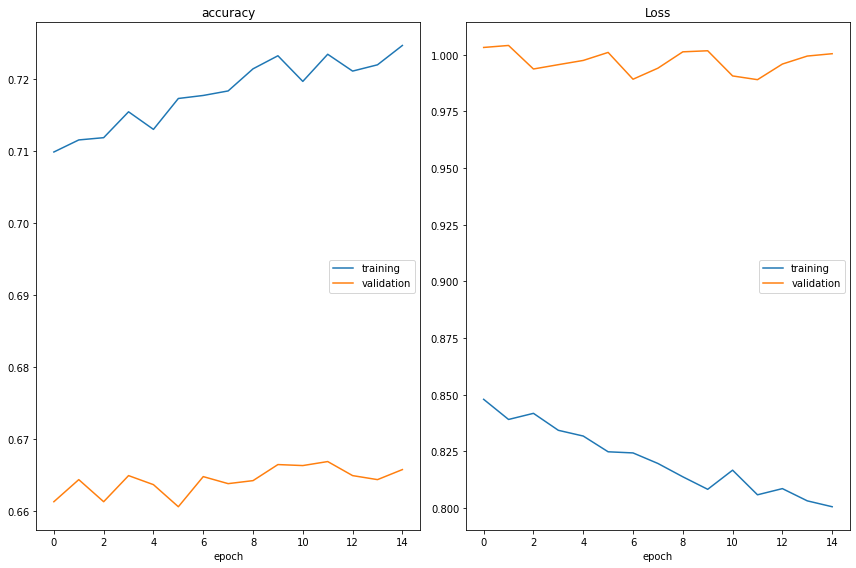

accuracy
	training         	 (min:    0.710, max:    0.725, cur:    0.725)
	validation       	 (min:    0.661, max:    0.667, cur:    0.666)
Loss
	training         	 (min:    0.801, max:    0.848, cur:    0.801)
	validation       	 (min:    0.989, max:    1.004, cur:    1.000)

Epoch 00015: saving model to model_weights.h5


In [38]:
epochs = 15
steps_per_epoch= train_set.n//train_set.batch_size
validation_steps = validation_set.n//validation_set.batch_size

checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',
                            save_weights_only=True, mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss' , factor=0.1, patience=2, min_lr=0.00001,model='auto')

callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(
        x= train_set,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_set,
        validation_steps=validation_steps,
        callbacks=callbacks
)

In [41]:
score = model.evaluate(validation_set)
print('Test Accuracy: {}'.format(score[1]))

113/113 [==============================] - 1s 6ms/step - loss: 0.9986 - accuracy: 0.6658
Test Accuracy: 0.6657843589782715


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, None, None, None)  0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    640       
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 64)    256       
_________________________________________________________________
activation (Activation)      (None, None, None, 64)    0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 64)    0         
_________________________________________________________________
dropout (Dropout)            (None, None, None, 64)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 128)   2

In [ ]:
validation_set.x

[0.9625120759010315, 0.6486486196517944]

In [39]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model.predict(validation_set.x), axis=-1)
y_true = np.argmax(y_test, axis=-1)

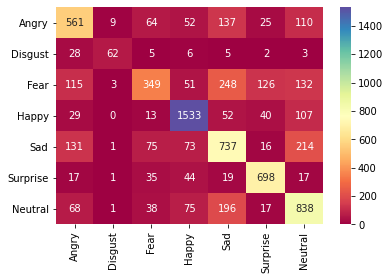

In [40]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_true, predicted_classes)
#plt.figure(figsize = (10, 10))
#sns.heatmap(cm, annot = True, cbar = False)
import seaborn as sns

sns.heatmap(mat, annot=True, fmt='d',cmap='Spectral', 
            yticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
            xticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])

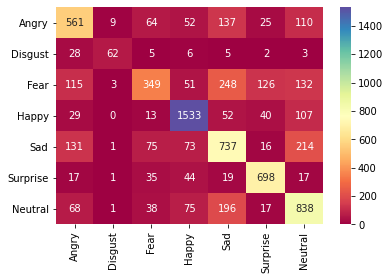

In [43]:
# predicted_classes = model.predict_classes(X_test)
predicted= np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_true, predicted)
#plt.figure(figsize = (10, 10))
#sns.heatmap(cm, annot = True, cbar = False)
import seaborn as sns

sns.heatmap(mat, annot=True, fmt='d',cmap='Spectral', 
            yticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
            xticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])

# Combining the 2 approaches

In [77]:
def string_to_array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

def resize(x):
  img = x.reshape(48, 48)
  return cv2.resize(img, dsize=(48, 48), interpolation = cv2.INTER_CUBIC)

In [78]:
dfO['pixel'] = dfO['pixel'].apply(lambda x: string_to_array(x))
dfO['pixel'] = dfO['pixel'].apply(lambda x: resize(x))

In [79]:
select = ['emotion', 'usage',	'pixel']
dataframe = dfO[select]
df_train = dataframe.loc[dataframe['usage'] == 'Training']
df_test = dataframe.loc[dataframe['usage'] != 'Training']
df_train_X = df_train['pixel']
df_train_Y = df_train['emotion']
df_test_X = df_test['pixel']
df_test_Y = df_test['emotion']

In [80]:
X_train = df_train_X
y_train = tf.keras.utils.to_categorical(df_train_Y)

X_test = df_test_X
y_test = tf.keras.utils.to_categorical(df_test_Y)

In [81]:
X_train = np.stack(X_train, axis = 0)
X_train = X_train.reshape(len(df_train_X), 48, 48, 1)

X_test = np.stack(X_test, axis = 0)
X_test = X_test.reshape(len(df_test_X), 48, 48, 1)

In [82]:
X_train = X_train / 255
X_test = X_test /255

### Geo

In [83]:
df_ = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataFrame.csv')
select = ['emotion',	'StabilityIndex_D',	'Skewness_D',	'Kurtosis_D',	'Moment_D_1',	'Moment_D_2',	'Moment_D_3',	'Moment_D_4',	'Entropy_D',	'Range_D',
'StabilityIndex_S',	'Skewness_S',	'Kurtosis_S',	'Moment_S_1',	'Moment_S_2',	'Moment_S_3',	'Moment_S_4',	'Entropy_S',	'Range_S',	
'StabilityIndex_T',	'Skewness_T',	'Kurtosis_T',	'Moment_T_1',	'Moment_T_2',	'Moment_T_3',	'Moment_T_4',	'Entropy_T',	'Range_T']
df_[select] =df_[select].apply(pd.to_numeric, errors='coerce')


In [84]:
select = ['emotion', 'usage',	'StabilityIndex_D',	'Skewness_D',	'Kurtosis_D',	'Moment_D_1',	'Moment_D_2',	'Moment_D_3',	'Moment_D_4',	'Entropy_D',	'Range_D',
'StabilityIndex_S',	'Skewness_S',	'Kurtosis_S',	'Moment_S_1',	'Moment_S_2',	'Moment_S_3',	'Moment_S_4',	'Entropy_S',	'Range_S',	
'StabilityIndex_T',	'Skewness_T',	'Kurtosis_T',	'Moment_T_1',	'Moment_T_2',	'Moment_T_3',	'Moment_T_4',	'Entropy_T',	'Range_T']

dataframe2 = df_[select]
df_train2 = dataframe2.loc[dataframe2['usage'] == 'Training']
df_test2 = dataframe2.loc[dataframe2['usage'] != 'Training']
df_train_X2 = df_train2.iloc[:, 2:len(dataframe2.iloc[0,])]
df_train_Y2 = df_train2.iloc[:, 0]
df_test_X2 = df_test2.iloc[:, 2:len(dataframe2.iloc[0,])]
df_test_Y2 = df_test2.iloc[:, 0]

In [85]:
sc = StandardScaler()
df_train_X2 = sc.fit_transform(df_train_X2)
df_test_X2 = sc.transform(df_test_X2)

In [86]:
y_train2 = tf.keras.utils.to_categorical(df_train_Y2, 7)
y_test2 = tf.keras.utils.to_categorical(df_test_Y2, 7)

## Model

In [138]:
#model = Sequential()
from keras.layers import Concatenate
# Conv Block 1
image =Input(shape=(48,48,1))
geo = Input(shape=(27,))

cnn = layers.ZeroPadding2D((3, 3))(image)

cnn = Conv2D(64, (3,3), padding='same', input_shape=(48,48,1))(cnn)
cnn = BatchNormalization()(cnn)
cnn = Activation('relu')(cnn)
cnn = MaxPooling2D(pool_size=(2,2))(cnn)
cnn = Dropout(0.25)(cnn)

# Conv Block 2
cnn = Conv2D(128,(5,5), padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = Activation('relu')(cnn)
cnn = MaxPooling2D(pool_size=(2,2))(cnn)
cnn = Dropout(0.25)(cnn)

# Conv Block 3
cnn = BatchNormalization()(cnn)
cnn = Conv2D(512,(3,3), padding='same')(cnn)
cnn = Activation('relu')(cnn)
cnn = MaxPooling2D(pool_size=(2,2))(cnn)
cnn = Dropout(0.25)(cnn)

# Conv Block 3
cnn = Conv2D(512,(3,3), padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = Activation('relu')(cnn)
cnn = MaxPooling2D(pool_size=(2,2))(cnn)
cnn = Dropout(0.25)(cnn)

cnn = Flatten()(cnn)

# Fully connected Block 1
cnn = Dense(256, kernel_regularizer=keras.regularizers.l2(0.01))(cnn)
cnn = BatchNormalization()(cnn)
cnn = Activation('relu')(cnn)
cnn = Dropout(0.25)(cnn)

# Fully connected Block 2
cnn = Dense(512, kernel_regularizer=keras.regularizers.l2(0.01))(cnn)
cnn = BatchNormalization()(cnn)
cnn = Activation('relu')(cnn)
cnn = Dropout(0.25)(cnn)


geo_layers = layers.Dropout(0.35, input_shape=(27,))(geo)

geo_layers = layers.Dense(units=512, activation = 'tanh')(geo_layers)
geo_layers = Dropout(0.35)(geo_layers)

geo_layers = layers.Dense(units=64, activation = 'tanh')(geo_layers)
geo_layers = Dropout(0.35)(geo_layers)

geo_layers = layers.Dense(units=16, activation = 'tanh')(geo_layers)
geo_layers = Dropout(0.35)(geo_layers)

co = Concatenate()([cnn,geo_layers])
output = Dense(512)(co)
output = BatchNormalization()(output)
output = Activation('relu')(output)
output = Dropout(0.25)(output)

output = Dense(7, activation='softmax')(output)

model = Model([image,geo], output)
opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [99]:
batch_size = 64
train_datagen = ImageDataGenerator( horizontal_flip=True)
  
train_set = train_datagen.flow(X_train, y_train, batch_size = 64)
validation_set = train_datagen.flow(X_test, y_test, batch_size = 64)

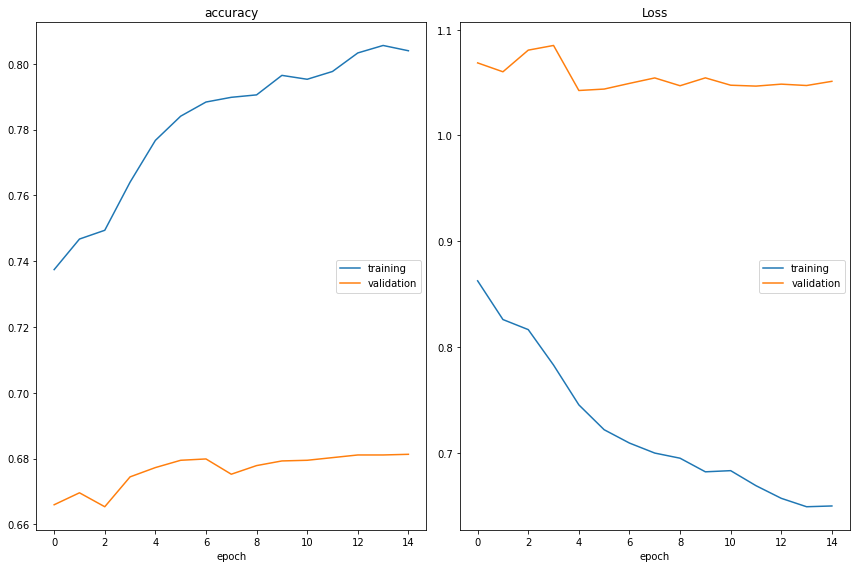

accuracy
	training         	 (min:    0.737, max:    0.806, cur:    0.804)
	validation       	 (min:    0.665, max:    0.681, cur:    0.681)
Loss
	training         	 (min:    0.649, max:    0.863, cur:    0.650)
	validation       	 (min:    1.043, max:    1.085, cur:    1.051)

Epoch 00015: saving model to model_weights.h5


In [140]:

epochs = 15
steps_per_epoch= train_set.n//train_set.batch_size
validation_steps = validation_set.n//validation_set.batch_size

checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',
                            save_weights_only=True, mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss' , factor=0.1, patience=2, min_lr=0.00001,model='auto')

callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(
        x= [train_set.x, df_train_X2], y = y_train,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=([validation_set.x, df_test_X2], y_test),
        validation_steps=validation_steps,
        callbacks=callbacks
)


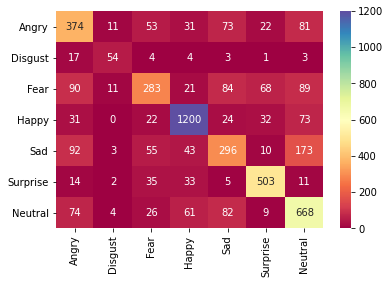

In [147]:
predicted= np.argmax(model.predict([validation_set.x, df_test_X2]), axis=-1)
y_true = np.argmax(y_test, axis=-1)

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_true, predicted)
#plt.figure(figsize = (10, 10))
#sns.heatmap(cm, annot = True, cbar = False)
import seaborn as sns

sns.heatmap(mat, annot=True, fmt='d',cmap='Spectral', 
            yticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
            xticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])

In [146]:
from sklearn.metrics import classification_report

report = classification_report(y_true, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.54      0.58      0.56       645
           1       0.64      0.63      0.63        86
           2       0.59      0.44      0.50       646
           3       0.86      0.87      0.86      1382
           4       0.52      0.44      0.48       672
           5       0.78      0.83      0.81       603
           6       0.61      0.72      0.66       924

    accuracy                           0.68      4958
   macro avg       0.65      0.64      0.64      4958
weighted avg       0.68      0.68      0.68      4958



In [143]:
score = model.evaluate([X_test, df_test_X2])
print('Test Accuracy: {}'.format(score[1]))

155/155 [==============================] - 0s 2ms/step - loss: 0.1141 - accuracy: 0.0000e+00
Test Accuracy: 0.0


# Else

In [ ]:
dfG['Moment_T_1'] = ""
dfG['Moment_T_2'] = ""
dfG['Moment_T_3'] = ""
dfG['Moment_T_4'] = ""
dfG['Moment_D_1'] = ""
dfG['Moment_D_2'] = ""
dfG['Moment_D_3'] = ""
dfG['Moment_D_4'] = ""
dfG['Moment_S_1'] = ""
dfG['Moment_S_2'] = ""
dfG['Moment_S_3'] = ""
dfG['Moment_S_4'] = ""
for j in range(0, len(dfG)):
  dfG['Moment_T_1'][j] = dfG['Moment_T'][j][0] 
  dfG['Moment_T_2'][j] = dfG['Moment_T'][j][1]  
  dfG['Moment_T_3'][j] = dfG['Moment_T'][j][2]  
  dfG['Moment_T_4'][j] = dfG['Moment_T'][j][3] 
  dfG['Moment_D_1'][j] = dfG['Moment_D'][j][0] 
  dfG['Moment_D_2'][j] = dfG['Moment_D'][j][1] 
  dfG['Moment_D_3'][j] = dfG['Moment_D'][j][2]  
  dfG['Moment_D_4'][j] = dfG['Moment_D'][j][3] 
  dfG['Moment_S_1'][j] = dfG['Moment_S'][j][0]  
  dfG['Moment_S_2'][j] = dfG['Moment_S'][j][1] 
  dfG['Moment_S_3'][j] = dfG['Moment_S'][j][2]  
  dfG['Moment_S_4'][j] = dfG['Moment_S'][j][3]  
  for i in range(2, 20):
    dfG.iloc[:, i][j] = np.asarray(dfG.iloc[:, i][j]).astype('float32')

  



  #dfG['Moment_D'][j] = np.asarray(dfG['Moment_D'][j]).astype('float32')
  #dfG['Moment_S'][j] = np.asarray(dfG['Moment_S'][j]).astype('float32')
  #dfG['Moment_T'][j] = np.asarray(dfG['Moment_T'][j]).astype('float32')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/i

In [ ]:
dfG = dfG.drop(columns=['Moment_T', 'Moment_D', 'Moment_S'])

In [ ]:
len(dfG.iloc[0, :])

29

In [ ]:
for i in range(0, len(df_)):
  a = np.array(df_["pixels"][i])
  df_["pixels"][i] = a.flatten()

NameError: ignored

In [ ]:
dfG_train = dfG.loc[dfG['usage'] == 'Training']
dfG_test = dfG.loc[dfG['usage'] != 'Training']
dfG_train_X = dfG_train.iloc[:, 2:len(dfG.iloc[0,])]
dfG_train_Y = dfG_train.iloc[:, 0]
dfG_test_X = dfG_test.iloc[:, 2:len(dfG.iloc[0,])]
dfG_test_Y = dfG_test.iloc[:, 0]


In [ ]:
df_.head()

,emotion,usage,pixels,landmarks,distance,NormalizedDistance,StabilityIndex_D,Skewness_D,Kurtosis_D,Entropy_D,Range_D,shape,NormalizedShape,StabilityIndex_S,Skewness_S,Kurtosis_S,Entropy_S,Range_S,Moment_D_1,Moment_D_2,Moment_D_3,Moment_D_4,Moment_S_1,Moment_S_2,Moment_S_3,Moment_S_4,texture,NormalizedTexture,StabilityIndex_T,Skewness_T,Kurtosis_T,Moment_T_1,Moment_T_2,Moment_T_3,Moment_T_4,Entropy_T,Range_T
0,0,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...","[{'chin': [(-1, 15), (-2, 22), (-2, 28), (-1, ...","[8.246211251235321, 16.0312195418814, 20.09975...","[5.0299575334557584e-05, 5.044810411287815e-05...",0.578346,-0.357767,-0.12663,5.67994,4.22983e-05,"[0.018565851724963202, 0.016660755854204744, 0...","[3.486179304053872e-05, 4.439667986854204e-05,...",4.52516,0.387636,1.22258,7.58859,0.000153598,0,6.09339e-11,-1.70172e-16,1.06686e-20,0,3.60887e-10,2.65755e-15,5.49946e-19,"[207, 30, 78, 255, 6, 135, 28, 255, 14, 239, 2...","[7.037273753348655e-05, 1.2893432343432902e-05...",0.0355298,0.115421,-0.452437,0,4.6713e-10,1.16531e-15,5.55904e-19,3.03636,7.63662e-05
1,0,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...","[{'chin': [(5, 25), (6, 29), (7, 33), (9, 37),...","[5.830951894845301, 13.341664064126334, 18.439...","[3.5567170809869274e-05, 4.19844326869658e-05,...",0.632856,-1.49053,5.21012,5.69618,3.8356e-05,"[0.016252431508165112, 0.012213344589299761, 0...","[3.0517797515390085e-05, 3.2545459197668165e-0...",4.83582,0.227092,0.469817,7.58465,0.000147518,0,2.25613e-11,-1.5973e-16,4.17905e-21,0,4.09738e-10,1.88349e-15,5.82531e-19,"[30, 141, 47, 31, 6, 55, 4, 252, 103, 229, 239...","[1.0198947468621239e-05, 6.059913201413464e-05...",0.0329649,0.0629759,-0.795289,0,3.9913e-10,5.02165e-16,3.51221e-19,3.04624,7.29507e-05
2,2,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...","[{'chin': [(7, 13), (5, 17), (4, 22), (3, 27),...","[7.0710678118654755, 13.0, 18.973665961010276,...","[4.313153001572831e-05, 4.090926156641289e-05,...",0.615182,-1.01666,2.34471,5.69727,3.3228e-05,"[0.016407877703908294, 0.008254641444375283, 0...","[3.080968464156224e-05, 2.1996521456920525e-05...",4.71292,0.331625,0.35232,7.5689,0.000134493,0,1.88021e-11,-8.2887e-17,1.88946e-21,0,4.35117e-10,3.00993e-15,6.34684e-19,"[88, 30, 254, 143, 30, 199, 7, 143, 254, 229, ...","[2.99169125746223e-05, 1.2893432343432902e-05,...",0.0414202,0.856728,2.43706,0,4.75928e-10,8.8952e-15,1.23154e-18,3.10652,0.00011382
3,6,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...","[{'chin': [(2, 20), (3, 25), (4, 30), (5, 35),...","[6.708203932499369, 14.035668847618199, 22.090...","[4.091816214528586e-05, 4.4168372934366603e-05...",0.704834,1.02034,11.4922,5.70133,3.53967e-05,"[0.021417735784386643, 0.013434560615715867, 0...","[4.021688222944737e-05, 3.579968952488622e-05,...",4.91672,0.0785708,0.373318,7.60682,0.000134295,0,9.90297e-12,3.17974e-17,1.42123e-21,0,3.54448e-10,5.24313e-16,4.23803e-19,"[28, 24, 62, 143, 38, 39, 60, 251, 124, 252, 2...","[9.519017637379822e-06, 1.0314745874746321e-05...",0.0339946,0.384538,0.118625,0,2.41001e-10,1.43869e-15,1.81134e-19,3.09737,6.62894e-05
4,2,Training,"[55, 55, 55, 55, 55, 54, 60, 68, 54, 85, 151, ...","[{'chin': [(3, 23), (4, 28), (4, 33), (5, 38),...","[7.0710678118654755, 13.601470508735444, 17.46...","[4.313153001572831e-05, 4.280200882536225e-05,...",0.646113,-0.496125,4.04168,5.69885,3.28988e-05,"[0.027249985751825634, 0.024292336919816138, 0...","[5.116831577193139e-05, 6.47329037725294e-05, ...",5.08187,11.1228,290.365,7.55396,0.000879859,0,1.6016e-11,-3.17995e-17,1.80627e-21,0,8.77294e-10,2.89022e-13,2.25787e-16,"[78, 15, 14, 14, 30, 206, 15, 239, 254, 231, 2...","[2.651726341841522e-05, 6.446716171716451e-06,...",0.0400248,-0.175007,-0.710022,0,4.44606e-10,-1.64066e-15,4.5267e-19,3.06151,6.97891e-05


In [ ]:
numeric = ['emotion','usage', 'pixels'] #'NormalizedShape', 'StabilityIndex_D', 'NormalizedTexture',	'Skewness_D',	'Kurtosis_D',	'Entropy_D',	'Range_D', 'StabilityIndex_S', 'Skewness_S',	'Kurtosis_S',	'Entropy_S',	'Range_S',	'Moment_D_1',	'Moment_D_2',	'Moment_D_3',	'Moment_D_4',	'Moment_S_1',	'Moment_S_2',	'Moment_S_3',	'Moment_S_4',	'StabilityIndex_T', 	'Skewness_T',	'Kurtosis_T',	'Moment_T_1',	'Moment_T_2',	'Moment_T_3',	'Moment_T_4',	'Entropy_T',	'Range_T']
dfO = df_[numeric]
len(dfO.iloc[0, :])


3

In [ ]:
type(dfO['pixels'][0])

array([ 70,  80,  82, ..., 106, 109,  82])

In [ ]:
dfO =pd.DataFrame(df[df['distance'] != ""].copy())
dfO.reset_index(inplace = True, drop = True) 
  

In [ ]:
dfO ['pixels'][0].shape

(48, 48)

In [ ]:
#sc = StandardScaler()
#dfO.iloc[:, 2:len(dfO.iloc[0, :])] = sc.fit_transform(dfO.iloc[:, 2:len(dfO.iloc[0, :])])
numeric = ['emotion','usage', 'pixels'] #'NormalizedShape', 'StabilityIndex_D', 'NormalizedTexture',	'Skewness_D',	'Kurtosis_D',	'Entropy_D',	'Range_D', 'StabilityIndex_S', 'Skewness_S',	'Kurtosis_S',	'Entropy_S',	'Range_S',	'Moment_D_1',	'Moment_D_2',	'Moment_D_3',	'Moment_D_4',	'Moment_S_1',	'Moment_S_2',	'Moment_S_3',	'Moment_S_4',	'StabilityIndex_T', 	'Skewness_T',	'Kurtosis_T',	'Moment_T_1',	'Moment_T_2',	'Moment_T_3',	'Moment_T_4',	'Entropy_T',	'Range_T']
dfO = dfO[numeric]
dfO_train = dfO.loc[dfG['usage'] == 'Training']
dfO_test = dfO.loc[dfG['usage'] != 'Training']
dfO_train_X = dfO_train.iloc[:, 2:len(dfG.iloc[0,])]
dfO_train_Y = dfO_train.iloc[:, 0]
dfO_test_X = dfO_test.iloc[:, 2:len(dfG.iloc[0,])]
dfO_test_Y = dfO_test.iloc[:, 0]

In [ ]:
df_ = dfG.loc[dfG['usage'] == 'Training']
dfG_test = dfG.loc[dfG['usage'] != 'Training']
dfG_train_X = dfG_train.iloc[:, 2:len(dfG.iloc[0,])]
dfG_train_Y = dfG_train.iloc[:, 0]
dfG_test_X = dfG_test.iloc[:, 2:len(dfG.iloc[0,])]
dfG_test_Y = dfG_test.iloc[:, 0]

In [ ]:
dfG["Moment_S_4"][0] * 10000000000000000

0.005499460026302929

In [ ]:

  classifier = Sequential()
  classifier.add(Convolution2D(32, 3, 3, input_shape = (48, 48, 3), activation= activation))

  #Max pooling
  classifier.add(MaxPooling2D(pool_size=(2,2)))

  # Flattening
  classifier.add(Flatten())

  #Full connection layers
  classifier.add(Dense(units= 128, activation='relu', ))
  classifier.add(Dense(units=  128, activation='relu', ))
  classifier.add(Dense(units = 7, activation='softmax', ))

  classifier.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


  classifier.fit(x = dfO_train_X, y = dfO_train_Y,
                  batch_size = 32,
                  steps_per_epoch=28709/32,
                  epochs=30,
                  validation_data=test_set,
                  callbacks = [es])

In [ ]:
  #image ogmentation
  train_datagen = ImageDataGenerator(
          rescale=1./255,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True)

  test_datagen = ImageDataGenerator(rescale=1./255)

  train_set = train_datagen.flow_from_directory( dfO_train_X,
                                                  target_size=(48, 48),
                                                  batch_size=32,
                                                  class_mode="categorical")

  test_set = test_datagen.flow_from_directory('C:/Users/Antonio franco/.spyder-py3/dataset/test',
                                              target_size=(48, 48),
                                              batch_size=32,
                                              class_mode="categorical")

In [ ]:
es = EarlyStopping(monitor= 'val_accuracy',
                   mode ='max',
                   patience = 5)

In [ ]:
classifier = Sequential()
classifier.add(Input(shape=(27,)))
classifier.add(Dense(256 , activation='relu'))
classifier.add(LeakyReLU(alpha=0.5))
classifier.add(Dense(1024 , activation='relu'))
classifier.add(LeakyReLU(alpha=0.5))
classifier.add(Dense(256 , activation='relu'))
classifier.add(LeakyReLU(alpha=0.5))
classifier.add(Dense(units = 7, activation='softmax', ))

In [ ]:
y_train = tf.keras.utils.to_categorical(dfO_train_Y, 7)
y_test = tf.keras.utils.to_categorical(dfO_test_Y, 7)

In [ ]:
len(dfO_train_X)

19984

In [ ]:
classifier.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier.fit(x=dfO_train_X , y=y_train ,
               batch_size = 32,
                steps_per_epoch=len(dfO_train_X)/32,
                epochs=100,
                validation_data = (dfO_test_X , y_test), callbacks = [es])

ValueError: ignored

In [ ]:
!pip install pyneurgen

     |████████████████████████████████| 583kB 12.5MB/s 
  Created wheel for pyneurgen: filename=pyneurgen-0.3.1-cp37-none-any.whl size=43733 sha256=5c8466e0ec0e03176a7180541c34363273ed44c5f0862e900b0ac63dde2453ea
  Stored in directory: /root/.cache/pip/wheels/34/85/2c/f272a1128673bb701853306cf5a543e8208581f7ccd8e105df
Successfully built pyneurgen


In [ ]:
from pyneurgen.recurrent import NARXRecurrent
...
#   NARXRecurrent
input_nodes = 27
hidden_nodes = 64
output_nodes = 7

output_order = 3
incoming_weight_from_output = .6
input_order = 2
incoming_weight_from_input = .4

net = NeuralNet()
net.init_layers(input_nodes, [hidden_nodes], output_nodes,
    NARXRecurrent(
        output_order,
        incoming_weight_from_output,
        input_order,
        incoming_weight_from_input))

net.randomize_network()

SyntaxError: ignored

In [ ]:
classifier.add(BatchNormalization())
classifier.add(Dense(64 , activation='relu'))
classifier.add(LeakyReLU(alpha=0.3))
classifier.add(Dropout(0.1))

In [ ]:
classifier.add(Dense(units = 7, activation='softmax', ))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.callbacks import EarlyStopping


es = EarlyStopping(monitor= 'val_accuracy',
                   mode ='max',
                   patience = 3)
# Initialising CNN
classifier = Sequential()

#convolution layer
classifier.add(Convolution2D(32, 3, 3, input_shape = (48, 48, 3), activation='relu'))

#Max pooling
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Flattening
classifier.add(Flatten())

#Full connection layers
classifier.add(Dense(units= 128, activation='relu', ))
classifier.add(Dense(units=  128, activation='relu', ))
classifier.add(Dense(units = 7, activation='softmax', ))

classifier.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#image ogmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

#train_set = train_datagen.flow_from_directory( dfO_train_X,
                                                target_size=(48, 48),
                                                batch_size=32,
                                                class_mode="categorical")

#test_set = test_datagen.flow_from_directory('C:/Users/Antonio franco/.spyder-py3/dataset/test',
                                            target_size=(48, 48),
                                            batch_size=32,
                                            class_mode="categorical")
classifier.fit(x = dfO_train_X, y = dfO_train_Y,
                batch_size = 32,
                steps_per_epoch=28709/32,
                epochs=30,
                validation_data=test_set,
                callbacks = [es])


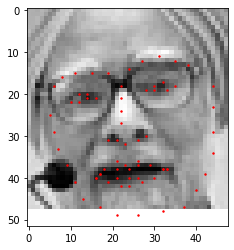

In [ ]:
arr = np.array(df['pixels'][1])
im = Image.fromarray(arr.astype(np.uint8), mode='L')
im.save('C:/Users/Antonio franco/Documents/Computer vision/dataset/my.png')
img = cv2.imread('C:/Users/Antonio franco/Documents/Computer vision/dataset/my.png', cv2.IMREAD_GRAYSCALE)
landmarks = face_recognition.face_landmarks(img)
xs = []
ys = []
for landmark in landmarks:
    for k, v in landmark.items():
        xs += [x[0] for x in v]
        ys += [x[1] for x in v]
        


fig, ax = plt.subplots()
ax.imshow(img, cmap="gray")
ax.scatter(x=xs, y=ys, c="r", s=2)

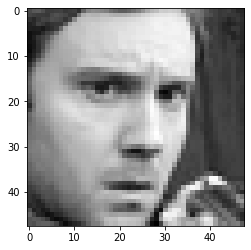

In [ ]:
plt.imshow(img, cmap="gray")

In [ ]:
len(df["landmarks"][0])


1

In [ ]:
arr = np.array(df['pixels'][0])
im = Image.fromarray(arr.astype(np.uint8), mode='L')
im.save('C:/Users/Antonio franco/Documents/Computer vision/dataset/my.png')
img = cv2.imread('C:/Users/Antonio franco/Documents/Computer vision/dataset/my.png', cv2.IMREAD_GRAYSCALE)
draw = plt.imshow(img, cmap='gray')

landmarks = df["landmarks"][0].get('chin')
for loc in landmarks:
    x,y = loc
    plt.plot(x, y, 'rx')
    #draw.rectangle((x, y, x+2, y+2), outline='blue')

AttributeError: 'list' object has no attribute 'get'

In [ ]:
df.head()

,emotion,usage,pixels,landmarks
0,0,Training,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ...","[{'chin': [(-1, 15), (-2, 22), (-2, 28), (-1, ..."
1,0,Training,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,...","[{'chin': [(5, 25), (6, 29), (7, 33), (9, 37),..."
2,2,Training,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,...","[{'chin': [(7, 13), (5, 17), (4, 22), (3, 27),..."
3,4,Training,"[[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ...",[]
4,6,Training,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2...","[{'chin': [(2, 20), (3, 25), (4, 30), (5, 35),..."


emotion                                                    0
 Usage                                              Training
 pixels    70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
Name: 0, dtype: object

In [ ]:
detector = dlib.get_frontal_face_detector()
faces = detector(   )